### In this notebook, we examine the location of houses and generate a zoomable map that displays the sale price variance on each street. We noticed that although some neighborhoods had a large variance of prices, the variance decreased significantly at the street level. To address this, we explored the possibility of creating a new feature by grouping streets based on their mean sale price. This new feature improved the accuracy of our models, but we later discovered that it caused data leakage and removed it from our analysis.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
from haversine import haversine

# the below extension properly formats a cell after it is run
%load_ext nb_black 

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option('display.max_columns', 200)


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [4]:
# loading the csv that contains addresses so i can get lat and lon
real_estate = pd.read_csv("data/Ames_Real_Estate_Data.csv", index_col=0)


/var/folders/2g/w2gh47jx2d536k1lqy8yjms40000gn/T/ipykernel_43532/4073422877.py:2: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate = pd.read_csv("data/Ames_Real_Estate_Data.csv", index_col=0)


<IPython.core.display.Javascript object>

In [5]:
# Loading the housing_no_na csv
housing = pd.read_csv("data/housing_no_na.csv")


<IPython.core.display.Javascript object>

In [5]:
# Select columns from the housing and real_estate dataframes and merge them
locations = housing[["PID", "SalePrice", "Neighborhood"]].merge(
    real_estate[["GeoRefNo", "Prop_Addr"]],
    left_on="PID",
    right_on="GeoRefNo",
    how="left",
)

# Drop the redundant column GeoRefNo
locations.drop("GeoRefNo", axis=1, inplace=True)

# Add the city and state to the property address
locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: f"{x}, AMES, USA" if isinstance(x, str) else None
)

# The above code added duplicates since the real_estate csv had instances of a GeoRef number
# showing up more than once. This could be a result of a property selling more than once
# in the selected time frame
locations.drop_duplicates(subset=["PID"], keep="first", inplace=True)

locations

PID  SalePrice Neighborhood                       Prop_Addr
0     909176150     126000        SWISU      436 HAYWARD AVE, AMES, USA
1     905476230     139500      Edwards         3416 WEST ST, AMES, USA
3     911128020     124900       IDOTRR         320 S 2ND ST, AMES, USA
4     535377150     114000      OldTown     1524 DOUGLAS AVE, AMES, USA
5     534177230     227000       NWAmes    2304 FILLMORE AVE, AMES, USA
...         ...        ...          ...                             ...
2618  903205040     121000      BrkSide   1021 RIDGEWOOD AVE, AMES, USA
2619  905402060     139600      Edwards        3619 MARY CIR, AMES, USA
2620  909275030     145000      Crawfor  2140 SUNSET DR 2142, AMES, USA
2621  907192040     217500      CollgCr    5319 CLEMENS BLVD, AMES, USA
2622  906223180     215000      SawyerW      1025 VERMONT CT, AMES, USA

[2579 rows x 4 columns]

<IPython.core.display.Javascript object>

In [8]:
# Some of the addresses have the unit number such as in condo buildings.  This wont be useful for us so Im going 
# to remove the unit number which is found before the 1st comma.  Ex 19 Smith st 201, Ames, Iowa

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(ST )[^,]*,", " ST,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(LN )[^,]*,", " LN,", x)
)
locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(CT )[^,]*,", " CT,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(RD )[^,]*,", " RD,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(CIR )[^,]*,", " CIR,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(BLVD )[^,]*,", " BLVD,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(DR )[^,]*,", " DR,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(AVE )[^,]*,", " AVE,", x)
)
# This should be GLEN ST not GLEN and this code will fix that
locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(GLEN,)[^,]*,", " GLEN ST, AMES,", x)
)

<IPython.core.display.Javascript object>

In [6]:
# adding latitude and longitude to the locations dataframe (using google because it is faster)

# from geopy.geocoders import GoogleV3

# # create a geocoder object with your personal key
# geolocator = GoogleV3(REMOVED)

# # define a function to get the latitude and longitude for a given address
# def get_lat_lon(address):
#     location = geolocator.geocode(address)
#     if location:
#         return location.latitude, location.longitude
#     else:
#         return None, None

# # create new columns Latitude and Longitude by applying the function to Prop_Addr column
# locations['Latitude'], locations['Longitude'] = zip(*locations['Prop_Addr'].apply(get_lat_lon))


<IPython.core.display.Javascript object>

In [ ]:
# Looked into this in another notebook.  It looks like there are 20 observations that dont have a corresponding
# entry from the CSV file that contains the location information.  Since we are focusing on the location
# of the houses I will drop these observations since they wont help us
locations.dropna(inplace=True)

In [27]:
# Taking a look at the sale price of houses on the map of Ames. 
# Looks like there is a correlation with sale price and neighborhood.  Also with the individual streets
# within the neighborhoods.  This could be because they are close to something like a park or cemetary.
# Houses on cul de sacs and circles seem to have a higher price

# Loading the csv here to prevent having to run the geo locator service cell again to view this map
locations_temp = pd.read_csv("data/locations.csv")

import folium
import branca
from folium.plugins import MarkerCluster


# Calculate ten equally spaced intervals for sale prices
sale_price_min = locations_temp['SalePrice'].min()
sale_price_max = locations_temp['SalePrice'].max()
interval = (sale_price_max - sale_price_min) / 10
levels = [sale_price_min + interval * i for i in range(10)]
colors = branca.colormap.LinearColormap(['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'pink', 'brown', 'gray'],
                                        vmin=sale_price_min, vmax=sale_price_max)


# create map centered on Ames, Iowa
m = folium.Map(location=[42.0308, -93.6319], zoom_start=12)

# create a feature group for the locations
fg = folium.FeatureGroup(name='Locations')

# loop through the locations dataframe and add a circle marker for each location
for i, row in locations_temp.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    sale_price = row['SalePrice']
    for j in range(len(levels) - 1):
        if levels[j] <= sale_price < levels[j + 1]:
            color = colors(sale_price)
            break
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill_color=color,
        fill_opacity=0.7,
        popup=f'Sale Price: ${sale_price}',
    ).add_to(fg)

# add the feature group to the map
fg.add_to(m)

# add a layer control to the map
folium.LayerControl().add_to(m)

# # create the legend
legend = colors.caption = 'Sale Price'
for i in range(len(levels) - 1):
    legend += f'<br>{levels[i]:.2f} - {levels[i+1]:.2f}: <span style="color:{colors(levels[i])}">●</span>'
    
# # add the legend to the map
m.get_root().html.add_child(folium.Element(legend))


# display the map
m


<IPython.core.display.Javascript object>

In [15]:
# I'm going to add features to explore the information gained from the map.  The map shows correlation of
# the saleprice with the street the house is on, with the type of street (ie Cir vs Blvd), and
# a difference in the price of a house on different streets in the same neighborhood

def get_street_name(address):
    # This function extracts the street name from the address
    # The street name should be everything after the first number in the string that is not a space.
    # The street name should also continue up until the comma.
    # If there are any spaces in the street name, they should be replaced with underscores.
    parts = address.split(',')
    if len(parts) > 0:
        street = parts[0].split(' ', 1)[-1].replace(' ', '_')
        return street
    else:
        return ''

# Apply the get_street_name function to the Prop_Addr column to add a column that contains just the street name
locations['Street_name'] = locations['Prop_Addr'].apply(get_street_name)

# Combine the Neighborhood and street_name columns to create the Neighborhood_st column which will be useful
# when examining the relationship of the streets in a neighborhood to the sale price
locations['Neighborhood_st'] = locations['Neighborhood'] + '_' + locations['Street_name']


<IPython.core.display.Javascript object>

In [16]:
# Adding the Street type as well, such as St, Ave, Blvd etc
locations['Street_type'] = locations['Street_name'].str.rsplit('_', n=1).str[-1]

<IPython.core.display.Javascript object>

## Exploring Street Type Relationship with Sale Price ##

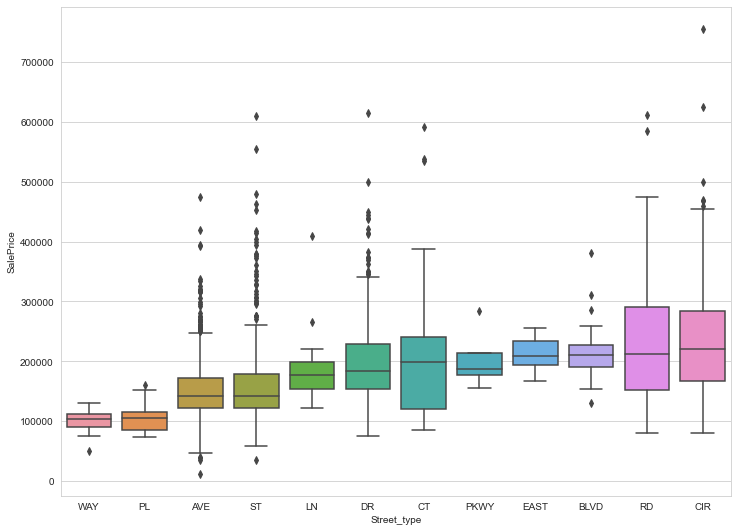

<IPython.core.display.Javascript object>

In [29]:
# Looking at the relationship Street_type has on SalePrice
# Calculate mean SalePrice for each Street_type to sort the boxplot
mean_saleprice = locations.groupby("Street_type")["SalePrice"].mean().reset_index()

# Sort by mean SalePrice
mean_saleprice_sorted = mean_saleprice.sort_values("SalePrice")

# Merge sorted mean SalePrice with the original DataFrame
locations_sorted = pd.merge(
    locations, mean_saleprice_sorted, on="Street_type", suffixes=("", "_mean")
)

# Plot the sorted DataFrame
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(
    x="Street_type",
    y="SalePrice",
    data=locations_sorted,
    order=mean_saleprice_sorted["Street_type"],
)
plt.show()

In [28]:
# for each group, we see that some Street_type groups, like CIR and RD, have relatively high standard
# deviations. This means that the SalePrice values for these groups are more variable or spread out,
# and there is more variability among the SalePrice values within each group. On the other hand,
# some groups like PKWY and WAY have lower standard deviations, which indicates that the SalePrice
# values for these groups are more clustered around the mean. In other words, there is less variability
# among the SalePrice values within each group and the SalePrice values tend to be closer to the mean.

locations.groupby("Street_type")["SalePrice"].agg(
    ["mean", "count", "std", "min", "max"]
)


mean  count            std     min     max
Street_type                                                     
AVE          150315.447126    870   50314.412886   12789  475000
BLVD         213474.489796     49   39912.451225  130000  381000
CIR          240307.721088    147  102140.274083   80000  755000
CT           203353.825000     80  102860.415078   85000  591587
DR           197196.396197    631   65622.104529   75000  615000
EAST         212362.500000      8   29156.618337  167900  255000
LN           188373.684211     19   64539.590280  122000  410000
None         155744.550000     20   94327.058827   34900  330000
PKWY         203612.500000      4   56212.252149  155000  284700
PL           105808.064516     31   23101.515451   73000  160250
RD           233157.621891    201   95074.286903   80000  611657
ST           160895.136905    504   69965.378418   35311  610000
WAY           99830.000000     15   19748.614780   50000  129850

<IPython.core.display.Javascript object>

## Exploring the Street Relationship with Sale Price ##

In [33]:
# taking a look at the relationship the street in a neighborhood with the SalePrice

# group by neighborhood and street
grouped = locations.groupby(["Neighborhood", "Street_name"])

# calculate count, mean, min, and max of SalePrice for each group
result = grouped.agg({"SalePrice": ["count", "mean", "min", "max", "std"]})

# flatten the resulting column names
result.columns = ["_".join(col).strip() for col in result.columns.values]

# reset the index to make Neighborhood and street_name columns
result = result.reset_index()

# convert SalePrice_mean to float
result["SalePrice_mean"] = result["SalePrice_mean"].astype(int)

# Replace NaN values with -1 (or any suitable value)
result["SalePrice_std"] = result["SalePrice_std"].fillna(-1)

# Round up the values using numpy's ceil function
result["SalePrice_std"] = np.ceil(result["SalePrice_std"])

# Convert the rounded values to integers
result["SalePrice_std"] = result["SalePrice_std"].astype(int)

# Street in each neighborhood looks promising to predict sale price 
print("SalePrice_std min:", result["SalePrice_std"].min())
print("SalePrice_std max:", result["SalePrice_std"].max())
print("SalePrice_std mean:", result["SalePrice_std"].mean())
print("SalePrice_std median:", result["SalePrice_std"].median())

# view the results
result

SalePrice_std min: -1
SalePrice_std max: 137958
SalePrice_std mean: 23373.131474103586
SalePrice_std median: 17951.5


Neighborhood         Street_name  SalePrice_count  SalePrice_mean  \
0        Blmngtn        BRICKMAN_AVE                3          166698   
1        Blmngtn         LAKESIDE_DR                5          213448   
2        Blmngtn         WESTWIND_DR               15          196408   
3        Blueste  LITTLE_BLUESTEM_CT               10          143590   
4         BrDale          BARKLEY_CT                8          102112   
..           ...                 ...              ...             ...   
497      Veenker       GREENSBORO_DR                2          241875   
498      Veenker          KINGMAN_RD                5          308800   
499      Veenker       PINEHURST_CIR                3          203833   
500      Veenker    TORREY_PINES_CIR                1          218000   
501      Veenker     TORREY_PINES_RD                3          203366   

     SalePrice_min  SalePrice_max  SalePrice_std  
0           159895         180000          11521  
1           185485         246578          27229  
2           160000         246990          24812  
3           115000         200000          30159  
4            85400         122500          14404  
..             ...            ...            ...  
497         165000         318750         108718  
498         192000         385000          77245  
499         162500         255000          47028  
500         218000         218000             -1  
501         181500         241600          33226  

[502 rows x 7 columns]

<IPython.core.display.Javascript object>

In [7]:
# The problem with using the neighborhood street combination is that there is over 500 value
# counts in a dataset with 2500 observations. This feature will definetly overfit the training data
locations["Neighborhood_st"].value_counts()

CollgCr_CLEMENS_BLVD     28
Gilbert_WELBECK_DR       25
NAmes_CLARK_AVE          22
BrkSide_RIDGEWOOD_AVE    22
NridgHt_HARRISON_RD      20
                         ..
StoneBr_WOODHAVEN_CIR     1
BrkSide_13TH_ST           1
NWAmes_HOOVER_AVE         1
NoRidge_GOLDENROD_CIR     1
NoRidge_HEMLOCK_CIR       1
Name: Neighborhood_st, Length: 512, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# The same issue with using just the the street name
locations["Street_name"].value_counts()

CLARK_AVE           38
CARROLL_AVE         29
EISENHOWER_AVE      28
NORTHWESTERN_AVE    28
CLEMENS_BLVD        28
                    ..
WESTFIELD_RD         1
ROOSEVELT_CIR        1
CRESCENT_ST          1
ARTHUR_CIR           1
HEMLOCK_CIR          1
Name: Street_name, Length: 444, dtype: int64

<IPython.core.display.Javascript object>

## Exploring Map Features Relationship to Sale Price ##

In [38]:
# Looked at the map created earlier and took note of several locations that seemed to affect the sale price



# Creating the coordinates of negative locations and positive locations
neg_locs = [('North Grand Mall', (42.049408, -93.609140)),
            ('Donald and Ruth Furman Aquatic Center', (42.011550, -93.635771)),
            ('Ames Municipal Cemetery', (42.033434, -93.616420))]
pos_locs = [('Jack Trice Stadium', (42.013916, -93.635853)),
            ('Ada Hayden Heritage Park', (42.073107, -93.684882)),
            ('Charles and June Calhoun Park', (42.033966, -93.649235))]



# Creating a function to calculate distances to negative and positive locations
def calc_distances(row):
    lat1, lon1 = row['Latitude'], row['Longitude']
    neg_distances = [haversine((lat1, lon1), loc[1]) for loc in neg_locs]
    pos_distances = [haversine((lat1, lon1), loc[1]) for loc in pos_locs]
    row['Neg_Loc_Dist'] = min(neg_distances)
    row['Pos_Loc_Dist'] = min(pos_distances)
    return row

# Applying the function to each row of the dataframe and save the results
locations = locations.apply(calc_distances, axis=1)

locations




PID  SalePrice Neighborhood                      Prop_Addr  \
0     909176150     126000        SWISU     436 HAYWARD AVE, AMES, USA   
1     905476230     139500      Edwards        3416 WEST ST, AMES, USA   
2     911128020     124900       IDOTRR        320 S 2ND ST, AMES, USA   
3     535377150     114000      OldTown    1524 DOUGLAS AVE, AMES, USA   
4     534177230     227000       NWAmes   2304 FILLMORE AVE, AMES, USA   
...         ...        ...          ...                            ...   
2554  903205040     121000      BrkSide  1021 RIDGEWOOD AVE, AMES, USA   
2555  905402060     139600      Edwards       3619 MARY CIR, AMES, USA   
2556  909275030     145000      Crawfor      2140 SUNSET DR, AMES, USA   
2557  907192040     217500      CollgCr   5319 CLEMENS BLVD, AMES, USA   
2558  906223180     215000      SawyerW     1025 VERMONT CT, AMES, USA   

       Latitude  Longitude    Street_name        Neighborhood_st Street_type  \
0     42.017814 -93.651428    HAYWARD_AVE      SWISU_HAYWARD_AVE         AVE   
1     42.024709 -93.664168        WEST_ST        Edwards_WEST_ST          ST   
2     42.021406 -93.614914       S_2ND_ST        IDOTRR_S_2ND_ST          ST   
3     42.038088 -93.612085    DOUGLAS_AVE    OldTown_DOUGLAS_AVE         AVE   
4     42.044900 -93.631893   FILLMORE_AVE    NWAmes_FILLMORE_AVE         AVE   
...         ...        ...            ...                    ...         ...   
2554  42.031974 -93.626550  RIDGEWOOD_AVE  BrkSide_RIDGEWOOD_AVE         AVE   
2555  42.027835 -93.666939       MARY_CIR       Edwards_MARY_CIR         CIR   
2556  42.019950 -93.643194      SUNSET_DR      Crawfor_SUNSET_DR          DR   
2557  42.016808 -93.690395   CLEMENS_BLVD   CollgCr_CLEMENS_BLVD        BLVD   
2558  42.031659 -93.682462     VERMONT_CT     SawyerW_VERMONT_CT          CT   

      Neg_Loc_Dist  Pos_Loc_Dist Street_10_Quantiles Street_20_Quantiles  \
0         1.469070      1.357705             group_4             group_7   
1         2.764819      1.606532             group_2             group_3   
2         1.343171      1.919875             group_2             group_3   
3         0.629324      3.102195             group_3             group_6   
4         1.805101      1.878609             group_7            group_14   
...            ...           ...                 ...                 ...   
2554      0.852223      1.886661             group_3             group_5   
2555      3.147736      1.613317             group_3             group_5   
2556      1.117355      0.904408             group_4             group_8   
2557      4.550501      3.898603             group_8            group_15   
2558      4.458274      2.756261             group_8            group_16   

     Street_30_Quantiles Street_50_Quantiles  
0               group_11            group_17  
1                group_5             group_8  
2                group_5             group_8  
3                group_8            group_13  
4               group_21            group_35  
...                  ...                 ...  
2554             group_8            group_13  
2555             group_7            group_11  
2556            group_11            group_18  
2557            group_22            group_37  
2558            group_24            group_39  

[2559 rows x 15 columns]

<IPython.core.display.Javascript object>

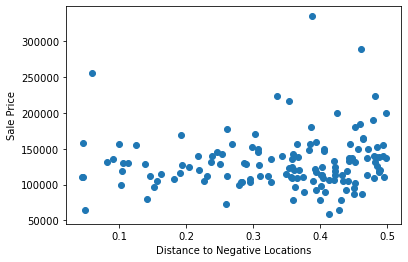

Correlation coefficient: 0.08243886574413524


<IPython.core.display.Javascript object>

In [20]:
# Determing if there is a linear relationship with negative map features and SalePrice
# Looks like no linear relationship however this is just the sale price vs distance
# and ist factoring in other variables such as house size etc


# filter the locations dataframe to only include observations that are less than 0.5 miles away from negative locations
locations_filtered = locations[(locations["Neg_Loc_Dist"] < 0.5)]


# create a scatter plot of Neg_Loc_Dist vs SalePrice
plt.scatter(locations_filtered["Neg_Loc_Dist"], locations_filtered["SalePrice"])
plt.xlabel("Distance to Negative Locations")
plt.ylabel("Sale Price")
plt.show()

# calculate the correlation between Neg_Loc_Dist and SalePrice
corr_coef = locations_filtered["Neg_Loc_Dist"].corr(locations_filtered["SalePrice"])
print("Correlation coefficient:", corr_coef)

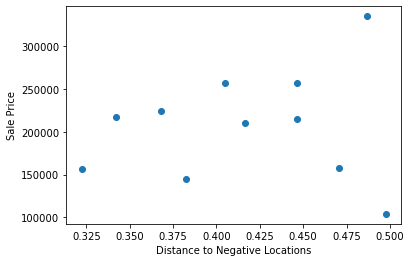

Correlation coefficient: 0.11722799927660844


<IPython.core.display.Javascript object>

In [21]:
# Doing the same with positive locations and with the same results

#  filter the locations dataframe to only include observations that are less than 0.5 miles away from negative locations
locations_filtered = locations[(locations["Pos_Loc_Dist"] < 0.5)]


# create a scatter plot of Neg_Loc_Dist vs SalePrice
plt.scatter(locations_filtered["Pos_Loc_Dist"], locations_filtered["SalePrice"])
plt.xlabel("Distance to Negative Locations")
plt.ylabel("Sale Price")
plt.show()

# calculate the correlation between Neg_Loc_Dist and SalePrice
corr_coef = locations_filtered["Pos_Loc_Dist"].corr(locations_filtered["SalePrice"])
print("Correlation coefficient:", corr_coef)

## The Street Name Relationship to SalePrice is Promising ##

In [31]:
# My solution for overfitting is putting several streets with a similar SalePrice into a group.  This solves 
# the problem of having 500 unique streets by creating groups(quantiles) and putting each street into 
# a group based on the mean SalePrice of the street. Another way to think of it is creating neighborhoods(groups)
# based on the mean saleprice of the street.  This idea will later lead to a new problem of data 
# leakage!



# Creating a function to put street into different groups.  Not sure on the best quantile(number of groups) so
# I will create several to see how they perform when we model

def group_streets_by_saleprice(df, num_quantiles=4):
    # Calculate the mean sale price for each street
    street_prices = df.groupby('Street_name')['SalePrice'].mean()
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f'group_{i+1}' for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=labels)
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    return street_group_dict


# Apply the function to create a dictionary for 10 quantiles
street_group_dict_10q = group_streets_by_saleprice(locations, num_quantiles=10)

# Apply the function to create a dictionary for 20 quantiles
street_group_dict_20q = group_streets_by_saleprice(locations, num_quantiles=20)

# Apply the function to create a dictionary for 30 quantiles
street_group_dict_30q = group_streets_by_saleprice(locations, num_quantiles=30)

# Apply the function to create a dictionary for 50 quantiles
street_group_dict_50q = group_streets_by_saleprice(locations, num_quantiles=50)



<IPython.core.display.Javascript object>

In [35]:
# adding them to the locations df

locations['Street_10_Quantiles'] = locations['Street_name'].map(street_group_dict_10q)

locations["Street_20_Quantiles"] = locations["Street_name"].map(street_group_dict_20q)

locations['Street_30_Quantiles'] = locations['Street_name'].map(street_group_dict_30q)

locations["Street_50_Quantiles"] = locations["Street_name"].map(street_group_dict_50q)



<IPython.core.display.Javascript object>

In [50]:
# there shouldnt be any missing values but am double checking

print(locations[['Street_10_Quantiles', 'Street_20_Quantiles', 'Street_30_Quantiles', 'Street_50_Quantiles']].isna().any())


Street_10_Quantiles    False
Street_20_Quantiles    False
Street_30_Quantiles    False
Street_50_Quantiles    False
dtype: bool


<IPython.core.display.Javascript object>

In [47]:
# Looks like 50 is the highest quantiles I should break them into

locations['Street_50_Quantiles'].value_counts()


group_12    139
group_9     107
group_33     83
group_18     81
group_7      74
group_22     72
group_35     68
group_43     67
group_17     66
group_20     66
group_32     66
group_13     63
group_14     61
group_24     61
group_29     60
group_37     59
group_11     58
group_6      57
group_31     56
group_16     55
group_23     53
group_15     52
group_41     52
group_5      51
group_44     50
group_34     49
group_10     49
group_30     49
group_39     47
group_4      43
group_3      43
group_8      42
group_28     41
group_48     40
group_49     40
group_26     38
group_47     37
group_25     35
group_38     34
group_19     33
group_21     33
group_27     32
group_40     31
group_45     30
group_36     29
group_46     29
group_2      28
group_42     26
group_1      24
group_50     20
Name: Street_50_Quantiles, dtype: int64

<IPython.core.display.Javascript object>

## Boxplots to Explore the Groups Created Based on Mean Street SalePrice ##

<AxesSubplot:xlabel='Street_30_Quantiles', ylabel='SalePrice'>

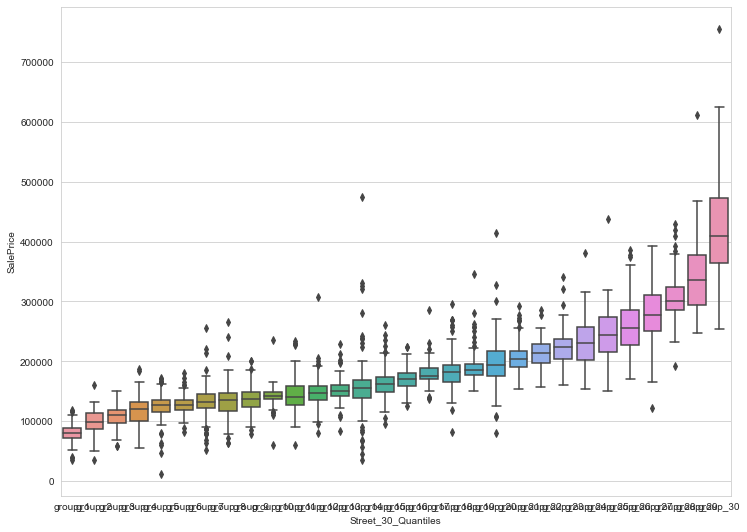

<IPython.core.display.Javascript object>

In [43]:
# calculate the mean SalePrice for each Street_50_Quantiles group
quantiles_means = locations.groupby("Street_50_Quantiles")["SalePrice"].mean()

# sort the quantiles in ascending order based on the mean SalePrice
sorted_quantiles = quantiles_means.sort_values().index

# plot the boxplot with the sorted order
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_30_Quantiles", y="SalePrice", data=locations, order=sorted_quantiles)


<AxesSubplot:xlabel='Street_10_Quantiles', ylabel='SalePrice'>

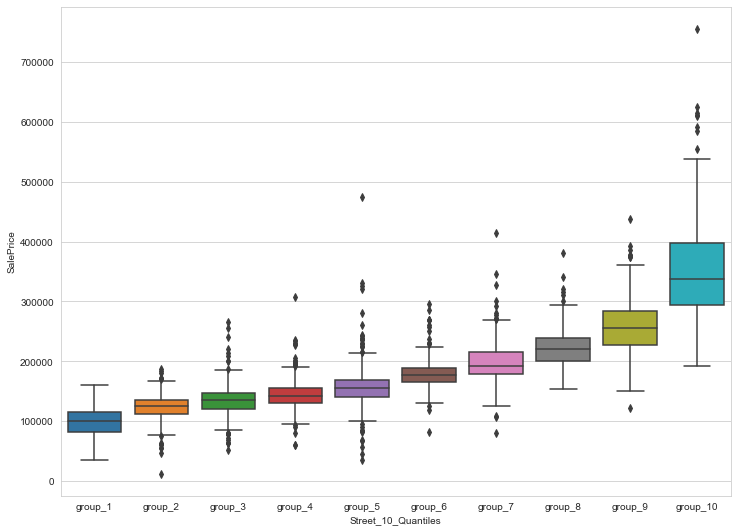

<IPython.core.display.Javascript object>

In [48]:
# calculate the mean SalePrice for each Street_10_Quantiles group
quantiles_means = locations.groupby("Street_10_Quantiles")["SalePrice"].mean()

# sort the quantiles in ascending order based on the mean SalePrice
sorted_quantiles = quantiles_means.sort_values().index

# plot the boxplot with the sorted order
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_10_Quantiles", y="SalePrice", data=locations, order=sorted_quantiles)


## Adding Promising Features to Housing_Cleaned ##

In [49]:
housing_cleaned = pd.read_csv("data/housing_cleaned.csv")


<IPython.core.display.Javascript object>

In [41]:
locations.shape

(2559, 15)

<IPython.core.display.Javascript object>

In [42]:
# Looks like housing cleaned still has the 20 observations with missing location data
housing_cleaned.shape

(2579, 90)

<IPython.core.display.Javascript object>

In [68]:
# reset the index of housing_cleaned
housing_cleaned = housing_cleaned.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [69]:
# adding the promising features to housing_cleaned
housing_cleaned = pd.merge(housing_cleaned, locations[['PID', 'Street_type', 'Street_10_Quantiles', 'Street_20_Quantiles', 'Street_30_Quantiles', 'Street_50_Quantiles']], on='PID', how='left')


<IPython.core.display.Javascript object>

In [82]:
# decided to add Prop_Addr and Street_name as well in case i want to get a better
# understanding of outliers in each group 
housing_cleaned = pd.merge(housing_cleaned, locations[['PID', 'Prop_Addr']], on='PID', how='left')

housing_cleaned = pd.merge(
    housing_cleaned, locations[["PID", "Street_name"]], on="PID", how="left"
)


<IPython.core.display.Javascript object>

In [46]:
# Later learned this dataframe will have data leakage from the street quantiles.  I will save it before
# I remove the quantiles and the 20 observations with location data missing in case it is needed later
housing_cleaned.to_csv("data/housing_cleaned_old.csv", index=False)

<IPython.core.display.Javascript object>

In [47]:
# dropping Quantiles that created data leakage and Street_name and Prop_addr because the focus will now
# be on the Neigborhood_st 
housing_cleaned = housing_cleaned.drop(
    columns=[
        "Street_name",
        "PoolQC",
        "Prop_Addr",
        "Street_10_Quantiles",
        "Street_20_Quantiles",
        "Street_30_Quantiles",
        "Street_50_Quantiles",
    ]
)
# Removing 20 observations with no address
housing_cleaned = housing_cleaned[housing_cleaned["Street_type"] != "None"]

<IPython.core.display.Javascript object>

In [48]:
# saving wasnt saving my changes so ill force encoding

# save the updated dataframe as a CSV file with UTF-8 encoding
housing_cleaned.to_csv('data/housing_cleaned.csv', index=False, encoding='utf-8')

<IPython.core.display.Javascript object>